# Create Inference Endpoint on Huggingface for PaliGemma 3B - Mix 448

Note: you might need to update `huggingface_hub` to the latest version with `pip install -U huggingface_hubg` to run this notebook.

Then, login to your Huggingface account with: `!huggingface-cli login`

In [8]:
import huggingface_hub
from huggingface_hub import create_inference_endpoint

## Create Inference Endpoint on Huggingface

Note that this costs $4 per hour.

In [9]:
# repository = "HuggingFaceM4/idefics2-8b"
# endpoint_name = "idefics2-8b-00"
# repository = "llava-hf/llava-v1.6-vicuna-13b-hf"
# endpoint_name = "llava-v1-6-vicuna-13b-hf-9ah"
repository = "google/paligemma-3b-mix-448"
endpoint_name = "paligemma-3b-mix-448-kqj"
namespace = "leloy"

In [ ]:
endpoint = create_inference_endpoint(
    endpoint_name,
    repository=repository,
    # namespace=namespace,
    framework="pytorch",
    task="text-generation",
    accelerator="gpu",
    vendor="aws",
    region="us-east-1",
    type="protected",
    instance_size="x4",  #"medium", 
    instance_type="nvidia-t4",  #"g5.2xlarge",
    min_replica=0,
    max_replica=1,
    custom_image={
        "health_route": "/health",
        "env": {
            "MAX_BATCH_PREFILL_TOKENS": "4096",
            "MAX_INPUT_LENGTH": "3072",
            "MAX_TOTAL_TOKENS": "8192",
            "MODEL_ID": "/repository"
        },
        # If you receive an error, try upgrading or downgrading the TGI image
        "url": "ghcr.io/huggingface/text-generation-inference:2.0.3",
    },
    token=huggingface_hub.get_token(),
)

endpoint.wait()
print(endpoint.status)

## Test

In [12]:
import requests
import base64
from io import BytesIO

import huggingface_hub
from transformers import LlavaNextProcessor
from PIL import Image

In [13]:
processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-vicuna-13b-hf")

In [54]:
def encode_local_image(image_path):
    # load image
    image = Image.open(image_path)

    # Convert the image to a base64 string
    buffer = BytesIO()
    image.save(buffer, format="JPEG")  # Use the appropriate format (e.g., JPEG, PNG)
    base64_image = base64.b64encode(buffer.getvalue()).decode('utf-8')

    # add string formatting required by the endpoint
    image_string = f"data:image/jpeg;base64,{base64_image}"

    return image_string

In [62]:
prompt_format = "<system_prompt> USER: <image>\\n<user> ASSISTANT: "

In [63]:
SYSTEM_PROMPT = "You are an infographics explainer. You will receive an image as an input and you must answer the user's question based on the image. Be concise and limit responses to at most 3 sentences, preferably one sentence long. Respond in English."

In [69]:
image_path = "data/raw_datasets/mydoc/images/0f92a234edfd0f9500ae813610f74c742f1044c5fa006a4f209bffc0bb4c9a81.png"

In [70]:
question = "What is the name of candidate in the document?"

"You are an infographics explainer. You will receive an image as an input and you must answer the user's question based on the image. Be concise and limit responses to at most 3 sentences, preferably one sentence long. Respond in English. USER: \\nWhat is the name of candidate in the document? ASSISTANT: "
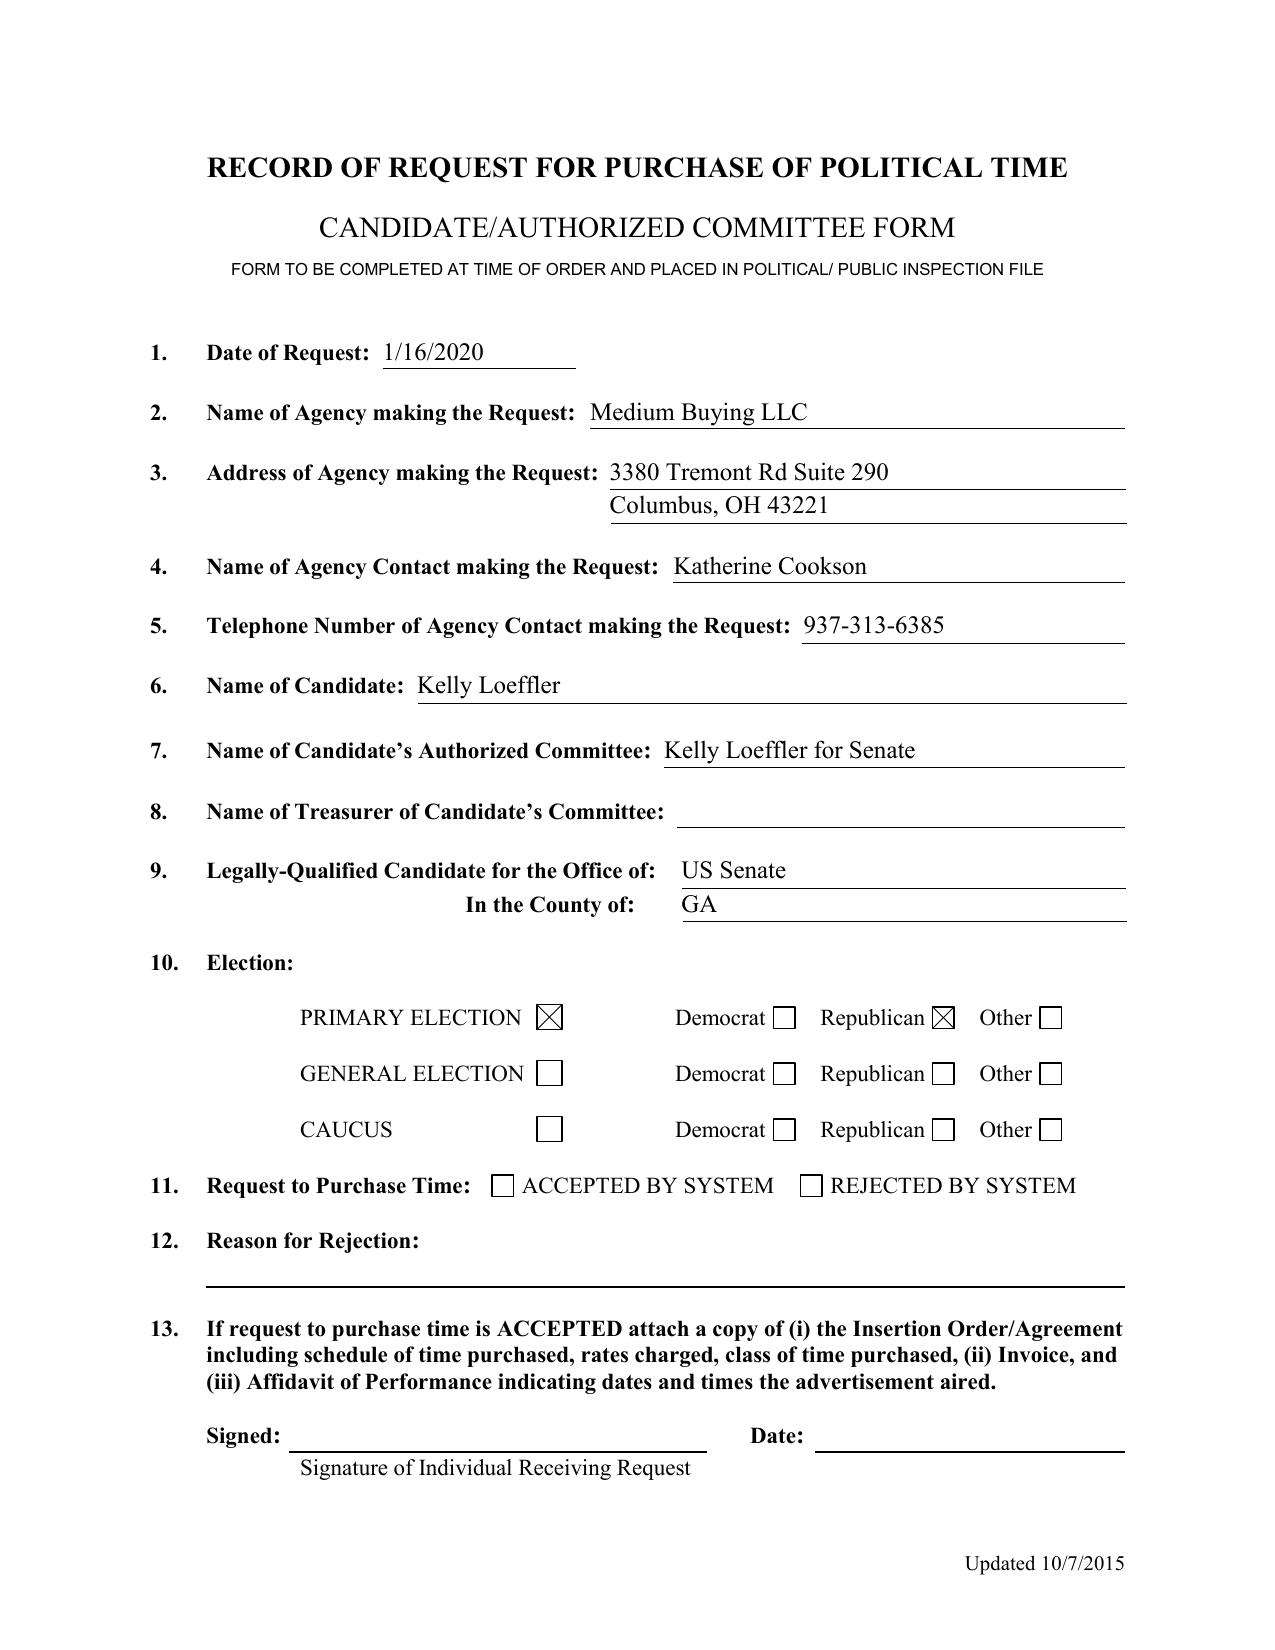

In [71]:
prompt = (
    prompt_format
    .replace("<system_prompt>", SYSTEM_PROMPT)
    .replace("<image>", f"![]({encode_local_image(image_path)})")
    .replace("<user>", question)
)
prompt

In [74]:
API_URL = "https://vft8ld0gc42q74xj.us-east-1.aws.endpoints.huggingface.cloud"
headers = {
	"Accept" : "application/json",
	"Authorization": f"Bearer {huggingface_hub.get_token()}",
	"Content-Type": "application/json" 
}

def query(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()


output = query({
	"inputs": prompt,
	"parameters": {
		"return_full_text": False,
		"max_new_tokens": 1024,
		"grammar": {
            "type": "json",
            "value": {
                "properties": {
					# This version of TGI uses an older version of Outlines
					# which re-orders the keys in the JSON in alphabetical order.
					# Hence the prefixes
                    "answer_reasoning": {
                        "type": "string"
                    },
                    "concise_answer": {
                        "type": "string"
                    },
                },
                "required": ["answer_reasoning", "concise_answer"]
            }
        }
	}
})

In [ ]:
output